In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 

from statsmodels.api import OLS
import sklearn.model_selection as skm
import sklearn.linear_model as skl
from sklearn.preprocessing import StandardScaler 
from ISLP import load_data
from functools import partial
from sklearn.model_selection import train_test_split
from ISLP.models import (ModelSpec as MS,
summarize , poly)

from sklearn.pipeline import Pipeline 
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression 
from ISLP.models import (Stepwise , sklearn_selected , sklearn_selection_path)

import itertools
import statsmodels.api as sm
from l0bnb import fit_path
import time

In [5]:
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd 

from statsmodels.datasets import get_rdataset 
import sklearn.model_selection as skm
from ISLP import load_data , confusion_table 
from ISLP.models import ModelSpec as MS

from sklearn.tree import (DecisionTreeClassifier as DTC, DecisionTreeRegressor as DTR, plot_tree , export_text)
from sklearn.metrics import (accuracy_score , log_loss) 
from sklearn.ensemble import (RandomForestRegressor as RF, GradientBoostingRegressor as GBR)
from ISLP.bart import BART

# Pruning a tree

In [6]:
import os
PathToRepo = os.path.normpath(os.getcwd() + os.sep + os.pardir)
Df = pd.read_csv('Faellesdata_cleaned.csv')

In [7]:
X_temp = Df.drop('IsMigratorInt', axis = 1)
model = MS(Df.columns.drop('IsMigratorInt'), intercept=False)
D = model.fit_transform(X_temp)
feature_names = list(D.columns)
X = np.asarray(D)

Fit the tree on the training data

In [8]:
x_train, x_test, y_train, y_test = train_test_split(X, Df['IsMigratorInt'], test_size = 0.2, random_state = 42)

Now we prune the tree to the optimal length. 

In [9]:
clf = DTC(criterion='entropy', random_state=0) 
clf.fit(x_train, y_train)
accuracy_score(y_test, clf.predict(x_test))

0.8135

Now we prune the tree to the optimal length. 

In [10]:
ccp_path = clf.cost_complexity_pruning_path(x_train, y_train) 

ccp_alphas = ccp_path.ccp_alphas
reduced_ccp_alphas = np.linspace(min(ccp_alphas), max(ccp_alphas), num=20)  # Select 20 equally spaced values

kfold = skm.KFold(10, random_state=1, shuffle=True)
grid = skm.GridSearchCV(clf, {'ccp_alpha': reduced_ccp_alphas}, refit=True, cv=kfold, scoring='accuracy') 

grid.fit(x_train, y_train)
grid.best_score_

0.8398554443053816

In [11]:
best_ = grid.best_estimator_ 
print('Test accuracy on pruned tree is', accuracy_score(y_test, best_.predict(x_test)))

Test accuracy on pruned tree is 0.829


Number of leaves: 8


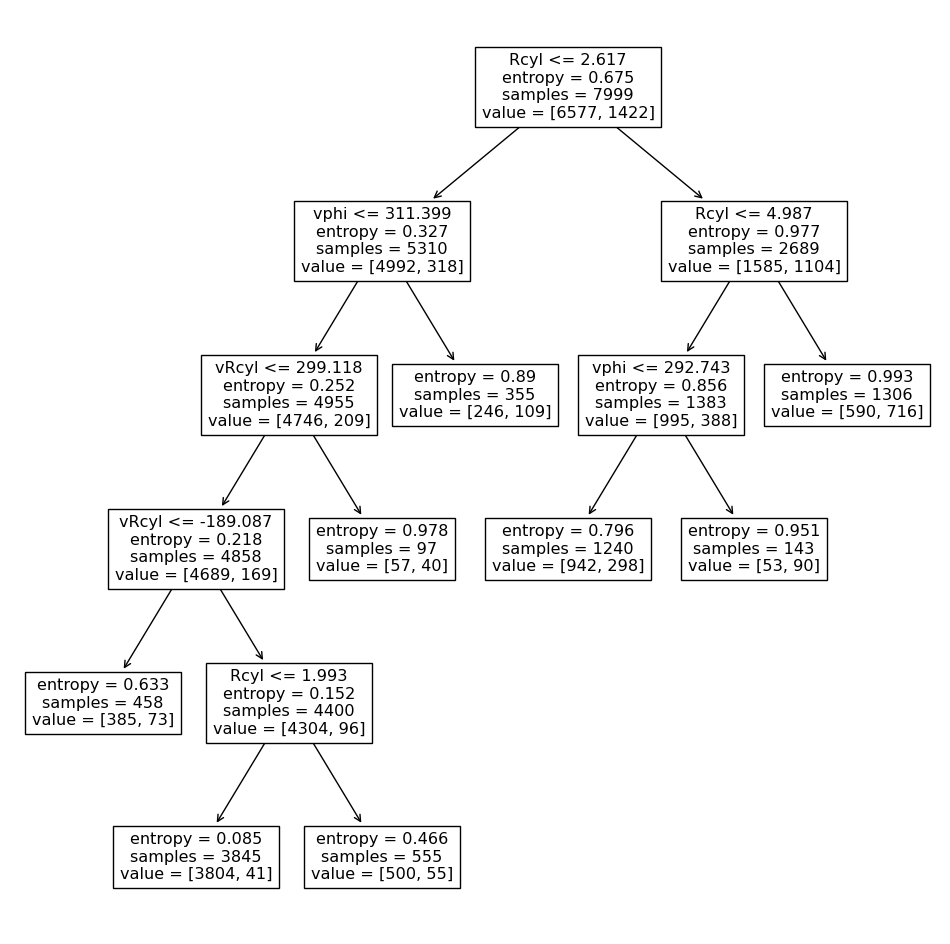

In [12]:
ax = plt.subplots(figsize=(12, 12))[1] 
plot_tree(best_, feature_names=feature_names, ax=ax);
print('Number of leaves:', best_.get_n_leaves())
plt.savefig(PathToRepo + '\\Plots\\DecisionTree.png')

In [13]:
confusion = confusion_table(best_.predict(x_test), y_test)
confusion

Truth,0,1
Predicted,,
0,1470,164
1,178,188


# Bagging

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

n_estimators are the number of trees in the forest. 

In [15]:
bag_migrater = RandomForestClassifier(n_estimators=100, max_features = x_train.shape[1], random_state=0, bootstrap=True)
bag_migrater.fit(x_train, y_train)

RandomForestClassifier(max_features=15, random_state=0)

In [16]:
print('Test accuracy using bagging', accuracy_score(y_test, bag_migrater.predict(x_test)))

Test accuracy using bagging 0.868


Importance of different variables. 

In [17]:
feature_imp = pd.DataFrame( {'importance': bag_migrater.feature_importances_}, index=feature_names)
feature_imp.sort_values(by='importance', ascending=False)

,importance
Rcyl,0.318441
vphi,0.140536
vRcyl,0.119667
vz,0.072615
z,0.054823
phi,0.054632
mass,0.049443
age,0.033590
ofe,0.032856
cfe,0.029225


Lets look at the confusion matrix 

In [18]:
confusion_bag = confusion_table(bag_migrater.predict(x_test), y_test)
confusion_bag

Truth,0,1
Predicted,,
0,1558,174
1,90,178


Since there is a lot of data wrongly classified lets look at the ROC curve

/var/folders/sh/wt6qzyds0ngfrmv3kkzq7rsr0000gn/T/ipykernel_44201/1009246308.py:12: RuntimeWarning: invalid value encountered in long_scalars
  precision = confusion[1][1]/(confusion[1][1] + confusion[0][1])


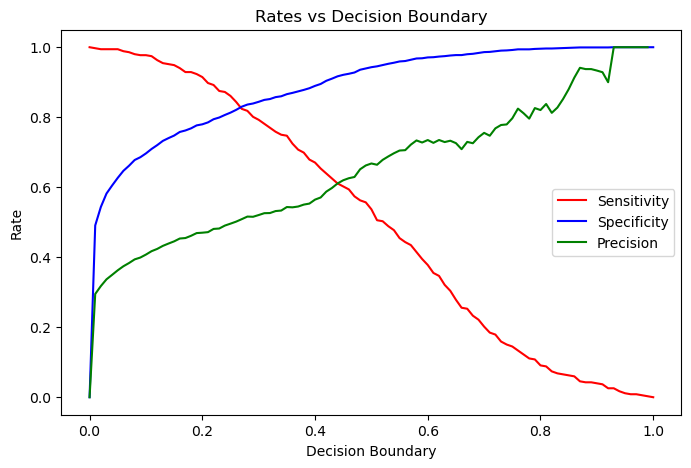

In [19]:
sensitivity_list = [1]
specificity_list = [0]
precision_list = [0]

decision_boundary = np.linspace(0, 1, 100)
decision_boundary_1 = np.linspace(0, 1, 101)

for i in decision_boundary:
    confusion = confusion_table(bag_migrater.predict_proba(x_test)[:,1] > i, y_test)
    sensitivity = confusion[1][1]/confusion[1].sum()
    specificity = confusion[0][0]/confusion[0].sum()
    precision = confusion[1][1]/(confusion[1][1] + confusion[0][1])
    sensitivity_list.append(sensitivity)
    specificity_list.append(specificity)
    precision_list.append(precision)

plt.figure(figsize = (8, 5))
plt.title('Rates vs Decision Boundary')
plt.plot(decision_boundary_1, sensitivity_list, label='Sensitivity', c = 'r')
plt.plot(decision_boundary_1, specificity_list, label='Specificity', c = 'b')
plt.plot(decision_boundary_1, precision_list, label='Precision', c = 'g')
plt.xlabel('Decision Boundary')
plt.ylabel('Rate')
plt.legend();
plt.savefig(PathToRepo + '\\Plots\\Rates_vs_DecisionBoundary.png')

As soon as decicionboundry ≠ 0 we get a lot of TN. 

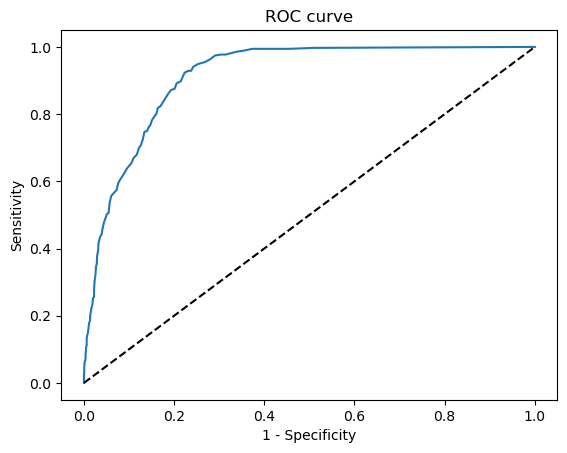

In [20]:
#make roc curve
from sklearn.metrics import roc_curve, roc_auc_score
fpr, tpr, thresholds = roc_curve(y_test, bag_migrater.predict_proba(x_test)[:,1])
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('1 - Specificity')
plt.ylabel('Sensitivity')
plt.title('ROC curve')
plt.savefig(PathToRepo + '\\Plots\\ROC_curve.png')
plt.show()

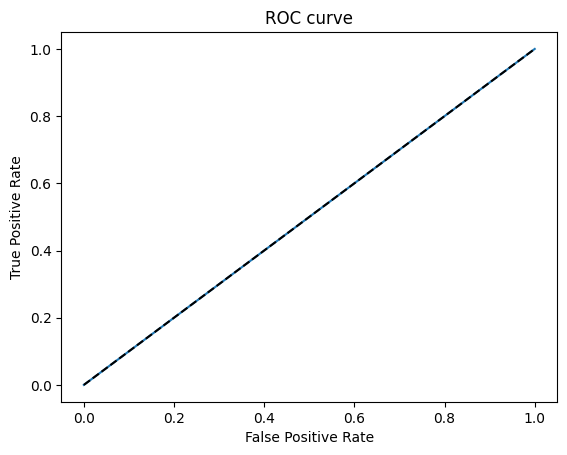

In [46]:
fpr, tpr, thresholds = roc_curve(y_test, np.zeros(len(y_test)))
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.savefig(PathToRepo + '\\Plots\\ROC_curve_0.png')
plt.show()

# Random forest
Do the same but vary the max_feauture argument for the RandomForestClassifier. 

In [26]:
accuracy_list = []
for i in range(1, x_train.shape[1] + 1):
    rf_migrator = RandomForestClassifier(n_estimators=100, max_features = i, random_state=0, bootstrap=True)
    rf_migrator.fit(x_train, y_train)
    accuracy = accuracy_score(y_test, rf_migrator.predict(x_test))
    accuracy_list.append(accuracy)    

In [48]:
accuracy_list_1 = []
for i in range(1, x_train.shape[1] + 1):
    rf_migrator = RandomForestClassifier(n_estimators=1000, max_features = i, random_state=1, bootstrap=True)
    rf_migrator.fit(x_train, y_train)
    accuracy = accuracy_score(y_test, rf_migrator.predict(x_test))
    accuracy_list_1.append(accuracy)    
    
accuracy_list_2 = []
for i in range(1, x_train.shape[1] + 1):
    rf_migrator = RandomForestClassifier(n_estimators=1000, max_features = i, random_state=2, bootstrap=True)
    rf_migrator.fit(x_train, y_train)
    accuracy = accuracy_score(y_test, rf_migrator.predict(x_test))
    accuracy_list_2.append(accuracy)    

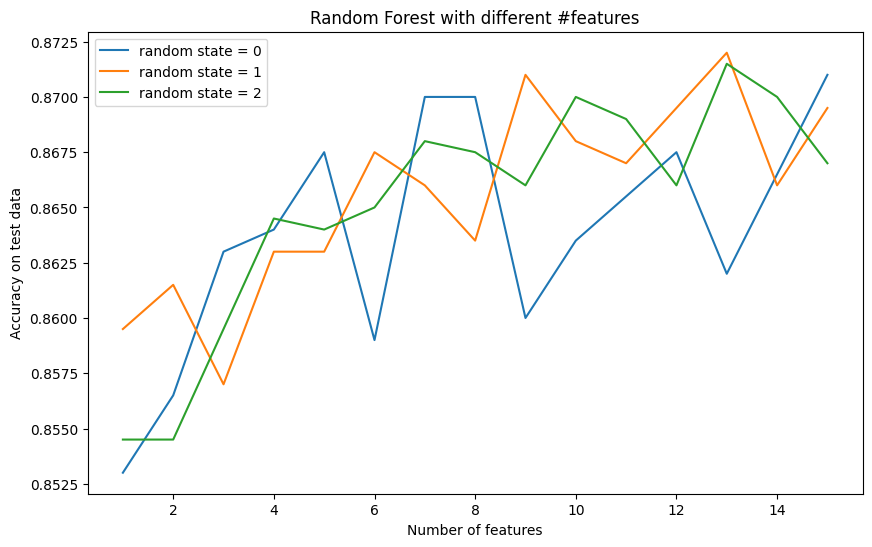

In [49]:
plt.figure(figsize=(10, 6))
plt.xlabel('Number of features')
plt.ylabel('Accuracy on test data')
plt.title('Random Forest with different #features')
plt.plot(range(1, x_train.shape[1] + 1), accuracy_list, label = 'random state = 0')
#plt.plot(range(1, x_train.shape[1] + 1), accuracy_list_1, label = 'random state = 1')
#plt.plot(range(1, x_train.shape[1] + 1), accuracy_list_2, label = 'random state = 2')
plt.savefig(PathToRepo + '\\Plots\\RandomForest.png')
plt.legend();

So we see a small increasing tendency but also that it varies from random state to random state what number of feautes are the best. However we can see that in general they are in between 0.855 and 0.870 which is a pretty small gap. 

# Boosting

In [21]:
from sklearn.ensemble import GradientBoostingClassifier

The argument n_estimators=1000 indicates that we want 1000 trees, and the option max_depth=3 limits the depth of each tree. The argument learning_rate is the $\lambda$ (i.e. the shrinkage parameter). 

In [22]:
boost_migrator = GradientBoostingClassifier(n_estimators = 1000, learning_rate=0.01, random_state=0)
boost_migrator.fit(x_train, y_train)
print('Test accuracy using boosting', accuracy_score(y_test, boost_migrator.predict(x_test)))

Test accuracy using boosting 0.874


Lets try different values of the learning_rate.

In [23]:
lambdas = np.linspace(0.05, 0.2, 10)
accuracy_list_boost = []
for i in lambdas: 
    boost_migrator = GradientBoostingClassifier(n_estimators = 1000, learning_rate=i, random_state=0)
    boost_migrator.fit(x_train, y_train)
    accuracy = accuracy_score(y_test, boost_migrator.predict(x_test))
    accuracy_list_boost.append(accuracy)

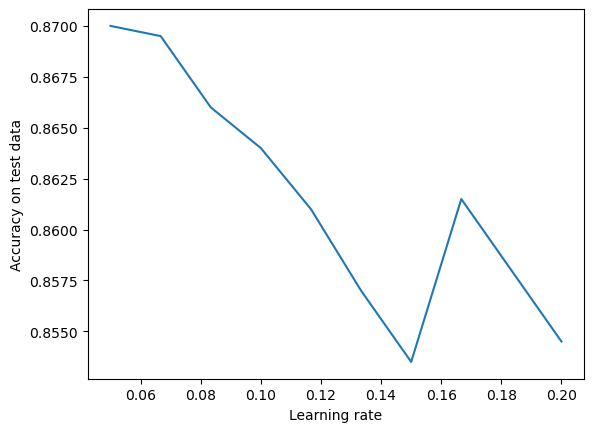

In [24]:
plt.plot(lambdas, accuracy_list_boost, label = 'Gradient Boosting')
plt.xlabel('Learning rate')
plt.ylabel('Accuracy on test data');
plt.savefig(PathToRepo + '\\Plots\\GradientBoosting.png')

Peak is a little weird. Otherwise makes sense that it is best with low values of $\lambda$

In [25]:
confusion = confusion_table(boost_migrator.predict(x_test), y_test)
confusion

Truth,0,1
Predicted,,
0,1531,174
1,117,178


.